In [1]:
import random

import torch
from torch import nn
import torch.nn.functional as F
import torch.distributed as dist

from tqdm import tqdm
from torchvision import transforms as T
import torchvision

In [2]:
from denoising_diffusion_pytorch import Unet, GaussianDiffusion
import torch

device = 'cuda'

m1 = Unet(
    dim = 64,
    dim_mults = (1, 2, 4, 8),
    flash_attn = True
)
m1.to(device)


diffusion = GaussianDiffusion(
    m1,
    image_size = 256,
    timesteps = 1000    # number of steps
)


diffusion.to(device)
m1_opt = torch.optim.Adam(diffusion.parameters(), lr=3e-4)

Non-A100 GPU detected, using math or mem efficient attention if input tensor is on cuda


In [3]:
BATCH_SIZE = 16

data_transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    # T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_content = torchvision.datasets.OxfordIIITPet(root='petdataset', split='trainval', download=True,  transform=data_transform)
# test_content = torchvision.datasets.OxfordIIITPet(root='petdataset', split='test', download=True,  transform=data_transform)

diffusion_train_dl = torch.utils.data.DataLoader(dataset=train_content, batch_size=BATCH_SIZE, shuffle=True)

In [9]:
epochs = 50
for epoch in range(epochs):
    for Ic, labels in tqdm(diffusion_train_dl, desc=f'Epoch {epoch}/{epochs}', leave=True):
        Ic, labels = Ic.to(device), labels.to(device)
        loss = diffusion(Ic)
        loss.backward()

        m1_opt.step()
        m1_opt.zero_grad()
    # if epoch % 100 == 0 or (epoch % 5 == 0 and epoch < 50):
    print("Loss:", loss.item())
    #     print("Content/Style: {}/{}".format(Lc.item(), Ls.item()))
    #     plot_style_transfer(Ic.cpu().detach(), Is.cpu().detach(), O.cpu().detach(), epoch, base_name)

Epoch 0/50: 100%|██████████| 230/230 [06:23<00:00,  1.67s/it]


Loss: 0.025018606334924698


Epoch 1/50:   1%|          | 2/230 [00:04<08:56,  2.35s/it]


KeyboardInterrupt: 

In [4]:
# torch.save(diffusion, 'diffusion_model_30.pth')
diffusion = torch.load('diffusion_model_30.pth')

In [30]:
sampled_images = diffusion.sample(batch_size = 4)
sampled_images.shape # (4, 3, 128, 128)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

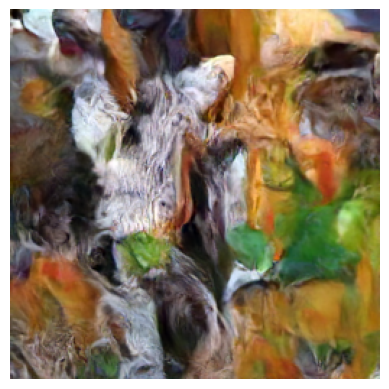

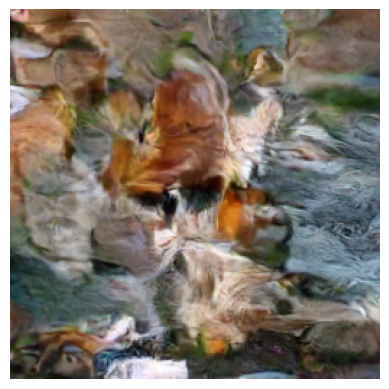

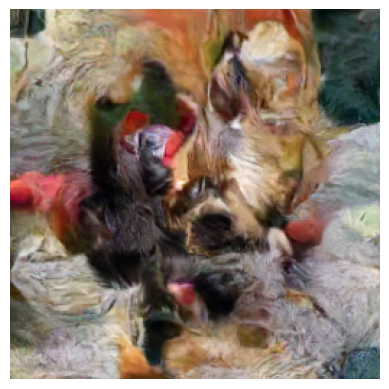

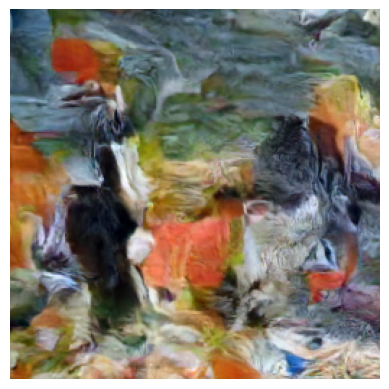

In [31]:
import matplotlib.pyplot as plt

images = sampled_images.cpu()
for i in range(images.shape[0]):
    # plt.subplot(1, 4, i + 1)  # Adjust subplot layout according to your batch size
    plt.imshow(images[i].permute(1, 2, 0))  # Matplotlib expects images in (H, W, C) format
    plt.axis('off')  # Turn off axis
    plt.show()


In [32]:
diffusion.eval()

GaussianDiffusion(
  (model): Unet(
    (init_conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (time_mlp): Sequential(
      (0): SinusoidalPosEmb()
      (1): Linear(in_features=64, out_features=256, bias=True)
      (2): GELU(approximate='none')
      (3): Linear(in_features=256, out_features=256, bias=True)
    )
    (downs): ModuleList(
      (0): ModuleList(
        (0-1): 2 x ResnetBlock(
          (mlp): Sequential(
            (0): SiLU()
            (1): Linear(in_features=256, out_features=128, bias=True)
          )
          (block1): Block(
            (proj): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
            (act): SiLU()
          )
          (block2): Block(
            (proj): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
            (act): SiLU()
          )
          (res_c

In [9]:
with torch.no_grad():
    for img, label in train_content:
        print(img.shape)
        img = img.to(device)
        time = torch.Tensor(200).to('cuda')
        m1(img.reshape(1, 3, 256, 256), time)

torch.Size([3, 256, 256])


OutOfMemoryError: CUDA out of memory. Tried to allocate 6.25 GiB. GPU 0 has a total capacity of 44.48 GiB of which 5.07 GiB is free. Process 1579277 has 10.77 GiB memory in use. Including non-PyTorch memory, this process has 28.64 GiB memory in use. Of the allocated memory 28.42 GiB is allocated by PyTorch, and 13.70 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)